# Secure Data Disclosure: Client side

This notebook showcases how researcher could use the Secure Data Disclosure system. It explains the different functionnalities provided by the `lomas_client` library to interact with the secure server.

The secure data are never visible by researchers. They can only access to differentially private responses via queries to the server.

Each user has access to one or multiple projects and for each dataset has a limited budget with $\epsilon$ and $\delta$ values.

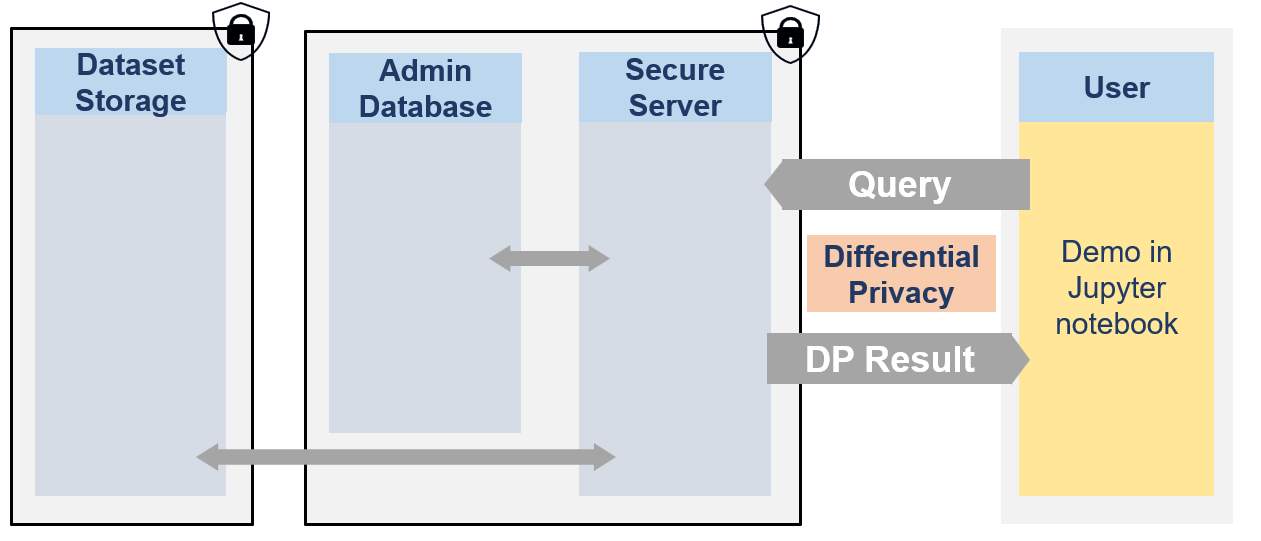

In [1]:
from IPython.display import Image
Image(filename="images/image_demo_client.png", width=800)

We will use the Synthetic Swiss Income Dataset to demonstrate the how to use the library `lomas_client` with polars queries.

## Step 1: Install the library

It can be installed via the pip command:

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# !pip install lomas_client

In [3]:
from lomas_client import Client
import numpy as np
import opendp.prelude as dp

## Step 2: Initialise the client

Once the library is installed, a Client object must be created. It is responsible for sending sending requests to the server and processing responses in the local environment. It enables a seamless interaction with the server. 

To create the client, we need to give it a few parameters:
- a url: the root application endpoint to the remote secure server.
- user_name: user name as registered in the database
- dataset_name: the name of the dataset that we want to query (FSO_INCOME_SYNTHETIC)

In [4]:
DATASET_NAME = "FSO_INCOME_SYNTHETIC"

In [5]:
# The following would usually be set in the environment by a system administrator
# and be tranparent to lomas users.
APP_URL = "http://localhost:48080"                                    # For local devenv setup
# APP_URL = "http://lomas_server:48080"                               # For local docker compose setup
# APP_URL = "http://lomas-server.example.com:80"                 # For Kubernetes deployment
USER_NAME = "Dr.FSO"

import os
os.environ["LOMAS_CLIENT_ID"] = USER_NAME
os.environ["LOMAS_CLIENT_SECRET"] = USER_NAME.lower()
os.environ["LOMAS_KEYCLOAK_ADDRESS"] = "localhost"                    # For local devenv setup
# os.environ["LOMAS_KEYCLOAK_ADDRESS"] = "keycloak"                   # For local docker compose setup
# os.environ["LOMAS_KEYCLOAK_ADDRESS"] = "lomas-keycloak.example.com" # For Kubernetes deployment 
os.environ["LOMAS_KEYCLOAK_PORT"] = "4442"                              # For local deployments
# os.environ["LOMAS_KEYCLOAK_PORT"] = "443"                           # For Kubernetes deployment
os.environ["LOMAS_KEYCLOAK_USE_TLS"] = "0"                            # For local deployments
# os.environ["LOMAS_KEYCLOAK_USE_TLS"] = "1"                          # For Kubernetes deployments
os.environ["LOMAS_REALM"] = "lomas"

In [6]:
client = Client(url=APP_URL, dataset_name=DATASET_NAME)

## Step 3: Metadata and dummy dataset

### Getting dataset metadata

Dr. FSO has never seen the data and as a first step to understand what is available to her, she would like to check the metadata of the dataset. Therefore, she just needs to call the `get_dataset_metadata()` function of the client. As this is public information, this does not cost any budget.

This function returns metadata information in a format based on [SmartnoiseSQL dictionary format](https://docs.smartnoise.org/sql/metadata.html#dictionary-format), where among other, there is information about all the available columns, their type, bound values (see Smartnoise page for more details). Any metadata is required for Smartnoise-SQL is also required here and additional information such that the different categories in a string type column column can be added.

In [7]:
income_metadata = client.get_dataset_metadata()
income_metadata

{'max_ids': 1,
 'rows': 2032543,
 'row_privacy': True,
 'censor_dims': False,
 'columns': {'region': {'private_id': False,
   'nullable': False,
   'max_partition_length': 474690,
   'max_influenced_partitions': None,
   'max_partition_contributions': None,
   'type': 'int',
   'precision': 32,
   'cardinality': 7,
   'categories': [1, 2, 3, 4, 5, 6, 7]},
  'eco_branch': {'private_id': False,
   'nullable': False,
   'max_partition_length': 34330,
   'max_influenced_partitions': None,
   'max_partition_contributions': None,
   'type': 'int',
   'precision': 32,
   'cardinality': 72,
   'categories': [8,
    10,
    11,
    13,
    14,
    15,
    16,
    17,
    18,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    35,
    37,
    38,
    41,
    42,
    43,
    45,
    46,
    47,
    49,
    50,
    52,
    53,
    55,
    56,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    68,
    69,
    7

### Get a dummy dataset

Now, that she has seen and understood the metadata, she wants to get an even better understanding of the dataset (but is still not able to see it). A solution to have an idea of what the dataset looks like it to create a dummy dataset. 

Based on the public metadata of the dataset, a random dataframe can be created created. By default, there will be 100 rows and the seed is set to 42 to ensure reproducibility, but these 2 variables can be changed to obtain different dummy datasets.
Getting a dummy dataset does not affect the budget as there is no differential privacy here. It is not a synthetic dataset and all that could be learn here is already present in the public metadata (it is created randomly on the fly based on the metadata).

Dr. FSO first create a dummy dataset with 200 rows and chooses a seed of 0.

In [8]:
NB_ROWS = 200
SEED = 0

In [9]:
dummy_lf = client.get_dummy_lf(nb_rows=NB_ROWS, seed = SEED)

dummy_lf.collect()

region,eco_branch,profession,education,age,sex,income
i32,i32,i32,i32,i32,i32,f64
6,27,94,5,111,1,1611.50605
5,52,33,8,24,0,72395.412826
4,35,81,6,41,0,67983.841861
2,27,25,5,113,1,66033.243543
3,88,41,4,119,0,69054.085229
…,…,…,…,…,…,…
7,77,93,1,119,0,37851.861395
3,74,33,7,21,0,21927.13039
7,95,72,4,51,1,41515.893667


In [10]:
test = client.get_dummy_dataset(nb_rows=NB_ROWS, seed = SEED)

In [11]:
test.dtypes

region          int32
eco_branch      int32
profession      int32
education       int32
age             int32
sex             int32
income        float64
dtype: object

## Step 4: Prepare the pipeline

It is necessary to prepare the pipeline before sending the query to the client.

In [12]:
import polars as pl

### a. mean

In [13]:
# Income bounds
income_lower_bound, income_upper_bound = income_metadata["columns"]["income"]["lower"], income_metadata["columns"]["income"]["upper"]

In [14]:
plan = dummy_lf.select(
    pl.col("income").dp.mean(bounds=(income_lower_bound, income_upper_bound), scale=(100,1)
))

## Step 5: Send the queries

### a. Dummy queries

In [15]:
res = client.opendp.query(plan, dummy = False, nb_rows = NB_ROWS, seed=SEED)

print(res.result.value)

/home/azureuser/work/sdd-poc-server/client/lomas_client/libraries/opendp.py:58: UserWarning: 'json' serialization format of LazyFrame is deprecated
  body_json["opendp_json"] = opendp_pipeline.serialize(format="json")


shape: (1, 1)
┌─────────────┐
│ income      │
│ ---         │
│ f64         │
╞═════════════╡
│ 7052.657714 │
└─────────────┘


By default, the client will use a laplace mechanism. Note that Dr. FSO can also use a Gaussian mechanism if wanted.

In [16]:
res = client.opendp.query(plan, mechanism = "gaussian", fixed_delta = 1.0, dummy = True, nb_rows = NB_ROWS, seed=SEED)

print(res.result.value)

shape: (1, 1)
┌─────────────┐
│ income      │
│ ---         │
│ f64         │
╞═════════════╡
│ 49551.53965 │
└─────────────┘


### b. budget estimation

In [17]:
res = client.opendp.cost(plan, mechanism = "laplace")

print(res)

epsilon=1.8346351313032196 delta=0.0


In [18]:
res = client.opendp.cost(plan, mechanism = "gaussian", fixed_delta = 0.001)

print(res)

epsilon=7.5318348577180965 delta=0.001


### c. Actual queries

In [19]:
res = client.opendp.query(plan, mechanism = "laplace")

print(res.result.value)

shape: (1, 1)
┌─────────────┐
│ income      │
│ ---         │
│ f64         │
╞═════════════╡
│ 7052.664729 │
└─────────────┘


In [20]:
res = client.opendp.query(plan, mechanism = "gaussian", fixed_delta = 0.001)

print(res.result.value)

shape: (1, 1)
┌─────────────┐
│ income      │
│ ---         │
│ f64         │
╞═════════════╡
│ 7052.664778 │
└─────────────┘


## Group_by examples

In [21]:
# Grouped by "sex"
plan = dummy_lf.group_by("sex").agg([
    pl.col("income").dp.mean(bounds=(income_lower_bound, income_upper_bound), scale=(100.0,1))
])

In [22]:
res = client.opendp.query(plan, dummy=True)
print(res.result.value)

shape: (2, 2)
┌─────┬──────────────┐
│ sex ┆ income       │
│ --- ┆ ---          │
│ i64 ┆ f64          │
╞═════╪══════════════╡
│ 1   ┆ 52396.828048 │
│ 0   ┆ 53883.149998 │
└─────┴──────────────┘


In [23]:
plan = dummy_lf.group_by(["sex","region"]).agg([
    pl.col("income").dp.mean(bounds=(income_lower_bound, income_upper_bound), scale=(100.0,1))
])

In [24]:
res = client.opendp.query(plan, dummy=True)

print(res.result.value)

shape: (14, 3)
┌─────┬────────┬──────────────┐
│ sex ┆ region ┆ income       │
│ --- ┆ ---    ┆ ---          │
│ i64 ┆ i64    ┆ f64          │
╞═════╪════════╪══════════════╡
│ 1   ┆ 2      ┆ 38531.333782 │
│ 0   ┆ 4      ┆ 93740.530829 │
│ 1   ┆ 6      ┆ 35213.421944 │
│ 0   ┆ 1      ┆ 54242.843613 │
│ 0   ┆ 3      ┆ 46599.655232 │
│ …   ┆ …      ┆ …            │
│ 0   ┆ 2      ┆ null         │
│ 0   ┆ 5      ┆ 61697.167977 │
│ 0   ┆ 6      ┆ 54648.316915 │
│ 0   ┆ 7      ┆ 31342.587703 │
│ 1   ┆ 1      ┆ 40140.414921 │
└─────┴────────┴──────────────┘


In [25]:
res = client.opendp.cost(plan, mechanism = "gaussian", fixed_delta = 0.001)

print(res)

epsilon=1.1015634949951034 delta=0.001


## Quantile examples

In [26]:
candidates = list(range(1_000, 100_000, 1000))

In [27]:
plan = dummy_lf.select(
    pl.col("income").dp.quantile(alpha=.75, candidates=candidates, scale=1.)
)

In [28]:
res = client.opendp.query(plan)

print(res.result.value)

shape: (1, 1)
┌────────┐
│ income │
│ ---    │
│ i64    │
╞════════╡
│ 8000   │
└────────┘


### Quantile with group_by

In [29]:
plan = dummy_lf.group_by("sex").agg([
    pl.col("income").dp.quantile(alpha=.25, candidates=candidates, scale=(1.)),
])

In [30]:
res = client.opendp.query(plan)

print(res.result.value)

shape: (2, 2)
┌─────┬────────┐
│ sex ┆ income │
│ --- ┆ ---    │
│ i64 ┆ i64    │
╞═════╪════════╡
│ 1   ┆ 6000   │
│ 0   ┆ 5000   │
└─────┴────────┘


### Quantile with group_by on mulitple columns

In [31]:
plan = dummy_lf.group_by(["sex", "region"]).agg([
    pl.col("income").dp.quantile(alpha=.75, candidates=candidates, scale=(1.)),
])

In [32]:
res = client.opendp.query(plan)

print(res.result.value)

shape: (14, 3)
┌─────┬────────┬────────┐
│ sex ┆ region ┆ income │
│ --- ┆ ---    ┆ ---    │
│ i64 ┆ i64    ┆ i64    │
╞═════╪════════╪════════╡
│ 0   ┆ 3      ┆ 8000   │
│ 1   ┆ 5      ┆ 8000   │
│ 0   ┆ 4      ┆ 8000   │
│ 1   ┆ 1      ┆ 9000   │
│ 1   ┆ 4      ┆ 9000   │
│ …   ┆ …      ┆ …      │
│ 0   ┆ 2      ┆ 7000   │
│ 0   ┆ 1      ┆ 8000   │
│ 1   ┆ 2      ┆ 9000   │
│ 0   ┆ 6      ┆ 8000   │
│ 1   ┆ 6      ┆ 9000   │
└─────┴────────┴────────┘


### Income distribution for partitions of the population:
#### Prepare the pipeline

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
# Partitions
PARTITIONS = ['sex', 'region']
# Prepare a list of candidates
candidates = [x * 250.0 for x in range(8, 52)]

In [35]:
def make_quantile_pipeline(quantile):
    # Create expression
    return dummy_lf.group_by(["sex", "region"]).agg([
        pl.col("income").dp.quantile(alpha=quantile, candidates=candidates, scale=1.),
    ])

In [36]:
q25 = make_quantile_pipeline(0.25)
q50 = make_quantile_pipeline(0.5)
q75 = make_quantile_pipeline(0.75)

In [37]:
r25 = client.opendp.query(q25)
r50 = client.opendp.query(q50)
r75 = client.opendp.query(q75)

/home/azureuser/work/sdd-poc-server/client/lomas_client/libraries/opendp.py:58: UserWarning: 'json' serialization format of LazyFrame is deprecated
  body_json["opendp_json"] = opendp_pipeline.serialize(format="json")


Let us put together the results and show them in a table. Notice that the output is a polars dataframe, we thus need to transform it to a pandas DataFrame if we want to work with pandas.

In [38]:
r25 = r25.result.value.to_pandas()
r50 = r50.result.value.to_pandas()
r75 = r75.result.value.to_pandas()

In [39]:
results = pd.merge(r25, r50, on=PARTITIONS, suffixes=('_25', '_50'))
results = pd.merge(results, r75, on=PARTITIONS)
results.sort_values(by = ['region', 'sex']).head()

,sex,region,income_25,income_50,income
2,0,1,5000.0,6250.0,7750.0
0,1,1,5750.0,7000.0,8750.0
1,0,2,4750.0,6000.0,7250.0
13,1,2,5500.0,7000.0,8500.0
3,0,3,5000.0,6250.0,7750.0


#### Visualise results

In [40]:
def quantile_data(q1, q2, q3):
    return np.concatenate((np.random.uniform(q1, q2, size=50), np.random.uniform(q2, q3, size=50)))

results['data'] = results.apply(
    lambda row: quantile_data(row["income_25"], row["income_50"], row["income"]),
    axis=1,
)
results['sex'] = results['sex'].replace({0: 'woman', 1: 'man'})
results['region'] = results['region'].replace({1: 'Lemanique', 2: 'Mittleland', 3: 'North-West', 4: 'Zürich', 5: 'Oriental', 6: 'Central', 7: 'Ticino'})
results = results.explode('data', ignore_index=True)

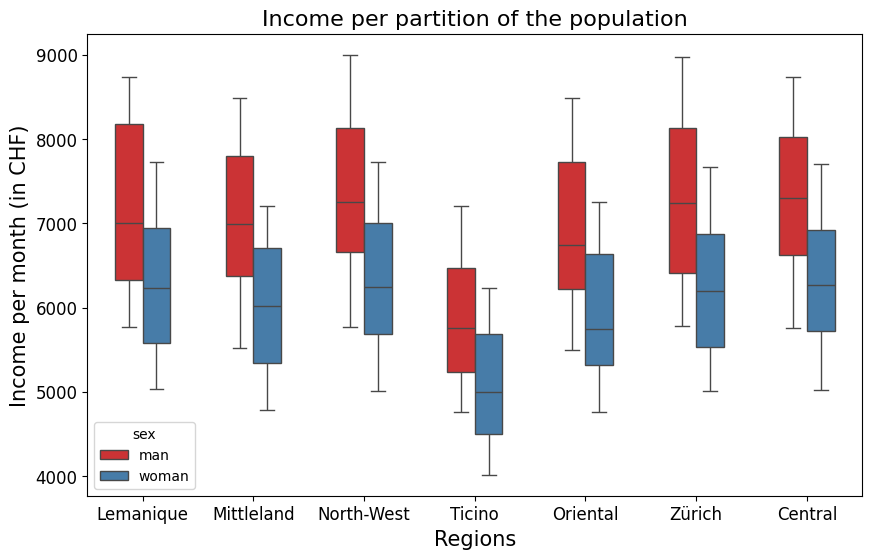

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="region", y="data", hue="sex", data=results, palette="Set1", width=0.5);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Regions', fontsize=15)
plt.ylabel('Income per month (in CHF)', fontsize=15)
plt.title('Income per partition of the population', fontsize=16)
plt.show()